# TransferLearning on Resnet (34)
this code has been modified from the official pytorch documentation and requires PyTorch compiled with CUDA support.
http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import PIL
import seaborn as sn
import pandas as pd
from confusionmeter import ConfusionMeter
plt.ion()   # interactive mode

# Load Data

In [3]:
# Data augmentation and normalization for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

data_dir = 'data/much_face'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

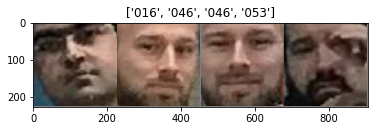

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

In [68]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

# Finetuning the convnet

In [6]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 53)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


# Train and Evaluate

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.8382 Acc: 0.3280
val Loss: 0.9668 Acc: 0.7604

Epoch 1/24
----------
train Loss: 0.7794 Acc: 0.8492
val Loss: 0.2470 Acc: 0.9393

Epoch 2/24
----------
train Loss: 0.2660 Acc: 0.9649
val Loss: 0.1446 Acc: 0.9521

Epoch 3/24
----------
train Loss: 0.1294 Acc: 0.9861
val Loss: 0.1148 Acc: 0.9681

Epoch 4/24
----------
train Loss: 0.1071 Acc: 0.9868
val Loss: 0.0701 Acc: 0.9776

Epoch 5/24
----------
train Loss: 0.0869 Acc: 0.9898
val Loss: 0.0888 Acc: 0.9808

Epoch 6/24
----------
train Loss: 0.0478 Acc: 0.9956
val Loss: 0.0828 Acc: 0.9808

Epoch 7/24
----------
train Loss: 0.0345 Acc: 0.9971
val Loss: 0.0893 Acc: 0.9776

Epoch 8/24
----------
train Loss: 0.0367 Acc: 0.9971
val Loss: 0.0866 Acc: 0.9744

Epoch 9/24
----------
train Loss: 0.0286 Acc: 0.9978
val Loss: 0.0839 Acc: 0.9712

Epoch 10/24
----------
train Loss: 0.0426 Acc: 0.9963
val Loss: 0.0770 Acc: 0.9681

Epoch 11/24
----------
train Loss: 0.0409 Acc: 0.9949
val Loss: 0.0647 Acc: 0.9840

Ep

Runs:
* ResNet18 Best val Acc: 0.968051
* ResNet 34 Best val Acc: 0.984026

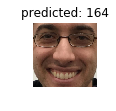

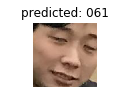

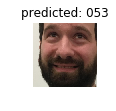

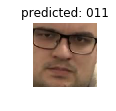

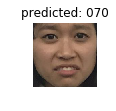

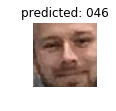

In [71]:
visualize_model(model_ft)

# Save the state dictionary

In [8]:
torch.save(model_ft.state_dict(), 'models/ResNet34_20180315.pth')

# Confusion Matrix

In [4]:
# e.g. modelname: initial_run20180307.pth 
model_dir = 'models'
def load_model(modelname,architecture):
    """
    modelname: e.g  initial_run20180307.pth  
    architecture: e.g resnet18
    """
    if architecture == 'resnet34':
        model_ft = models.resnet34(pretrained=False)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 53)
        model_checkpoint = torch.load(os.path.join(model_dir, modelname))
        model_ft.load_state_dict(model_checkpoint)
        return model_ft

In [5]:
model_ft = load_model('ResNet34_20180315.pth','resnet34')

In [6]:
confusion_matrix = ConfusionMeter(53,normalized=False) #we have 53 classes
model_ft.cuda() # enable computation on gpu 
model_ft.eval() # set model to evaluation mode
for data in dataloaders['val']: # loop through dataloader 
    inputs, labels = data
    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())
    outputs = model_ft(inputs) # pred
    _, preds = torch.max(outputs.data, 1) # get max
    confusion_matrix.add(preds.squeeze(), labels.data) # append to confusion matrix
array = confusion_matrix.conf

In [7]:
# define class_names
class_names = ['001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '035',
 '037',
 '045',
 '046',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '107',
 '108',
 '161',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '170']

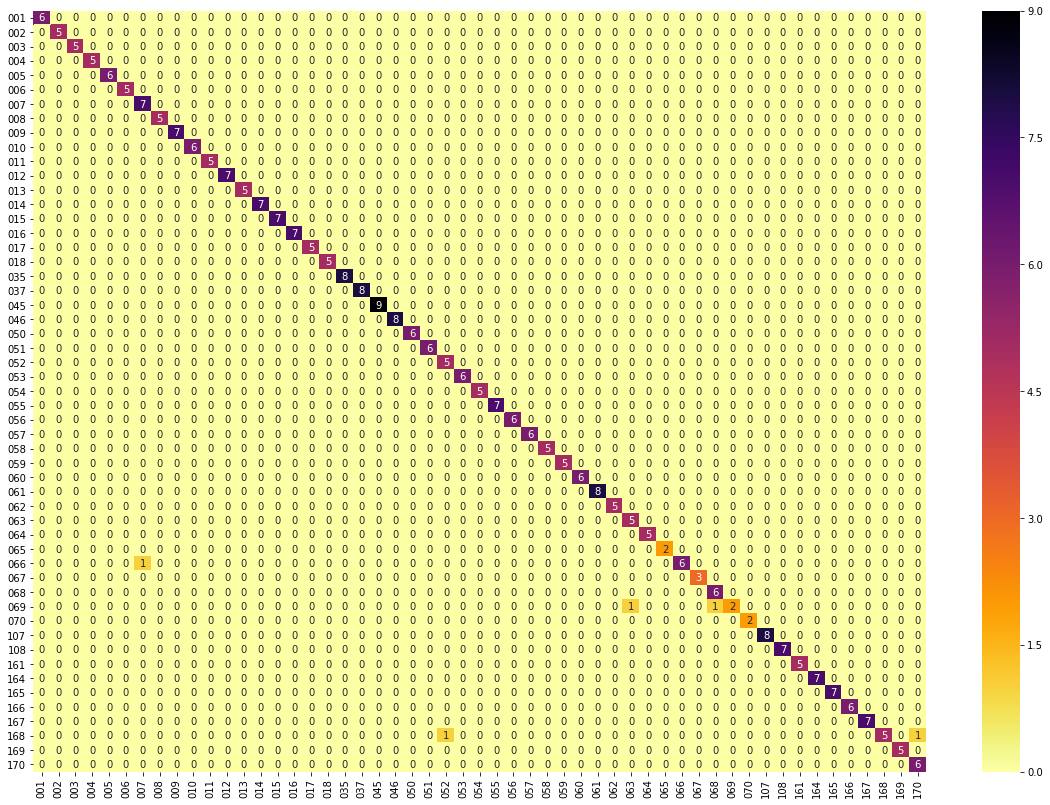

In [8]:
# Plot confusion matrix using seaborns heatmap
colormap = plt.cm.inferno_r
df_cm = pd.DataFrame(array, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (20,14))
heatmapplot = sn.heatmap(df_cm, annot=True,cmap=colormap)

In [77]:
# save the figure to disk
heatmapplot.figure.savefig("ConfusionMatrixResNet34.png")

In [9]:
# show dataset size
dataset_sizes

{'train': 1366, 'val': 313}